# Heart Failure Clinical Records: Modeling & Survival Analysis

**Goal:** Predict mortality and identify clinical risk factors using robust, interpretable models.


In [18]:
# 1. Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, roc_auc_score
)
from imblearn.over_sampling import SMOTE
import warnings
sns.set_palette("husl")
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')


## 2. Load Feature-Engineered Data


In [4]:
df = pd.read_csv('data/heart_failure_clean.csv')
df.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,age_group,comorbidity,log_creatinine_phosphokinase,log_serum_creatinine
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,70-80,1,6.368187,1.064711
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,<60,0,8.969796,0.741937
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,60-70,1,4.990433,0.832909
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,<60,1,4.718499,1.064711
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,60-70,2,5.081404,1.308333


## 3. Prepare Features and Handle Imbalance
- **Stratified split**
- **SMOTE oversampling**


In [19]:
features = [
    'age', 'ejection_fraction', 'serum_creatinine', 'platelets', 'time',
    'anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking',
    'comorbidity', 'log_creatinine_phosphokinase', 'log_serum_creatinine'
]
X = df[features]
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)
print("Class balance (train):")
print(y_train.value_counts())

# SMOTE oversampling on training set
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print("Class balance after SMOTE:")
print(pd.Series(y_res).value_counts())


Class balance (train):
DEATH_EVENT
0    152
1     72
Name: count, dtype: int64
Class balance after SMOTE:
DEATH_EVENT
1    152
0    152
Name: count, dtype: int64


## 4. Logistic Regression Assumption Checks
### (VIF, linearity, Cook's distance, perfect separation)


In [20]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X_res)
vif_df = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
display(vif_df)


,feature,VIF
0,const,152.401973
1,age,1.231128
2,ejection_fraction,1.188696
3,serum_creatinine,15.420940
4,platelets,1.051466
5,time,1.222637
6,anaemia,2.402068
7,diabetes,2.824188
8,high_blood_pressure,2.207107
9,sex,1.370414


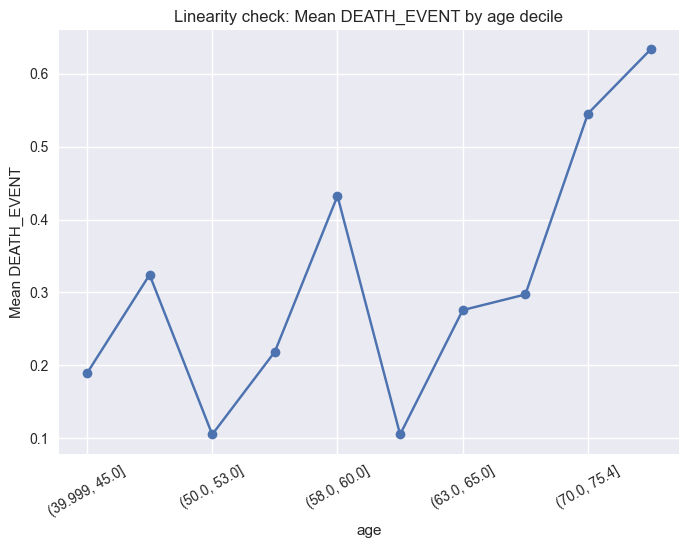

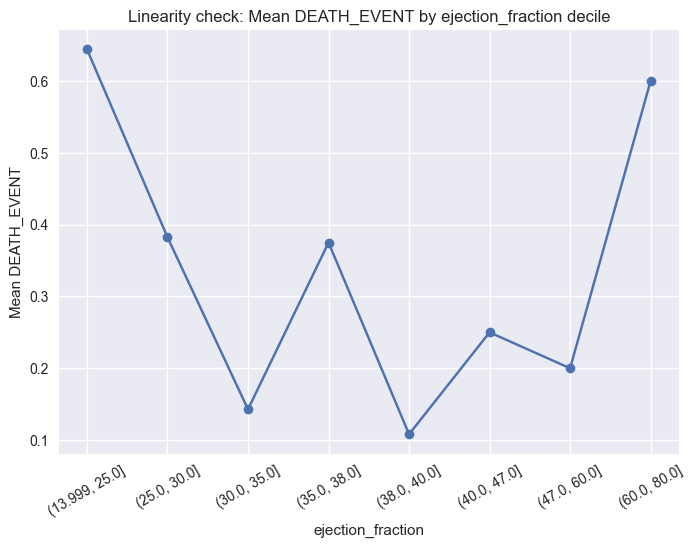

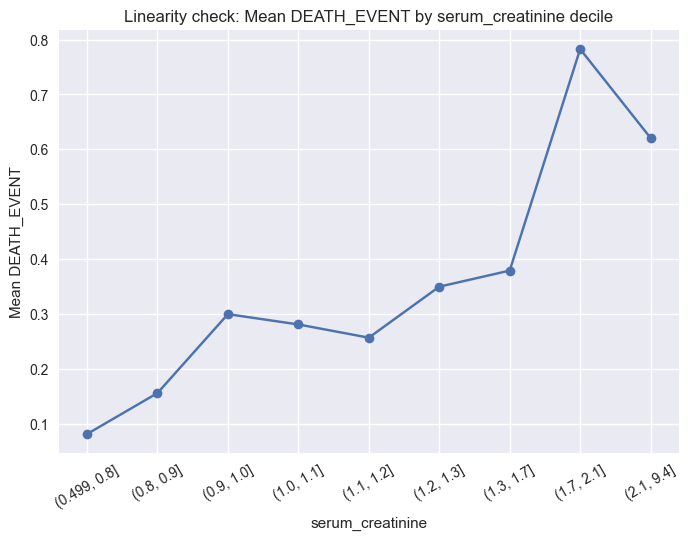

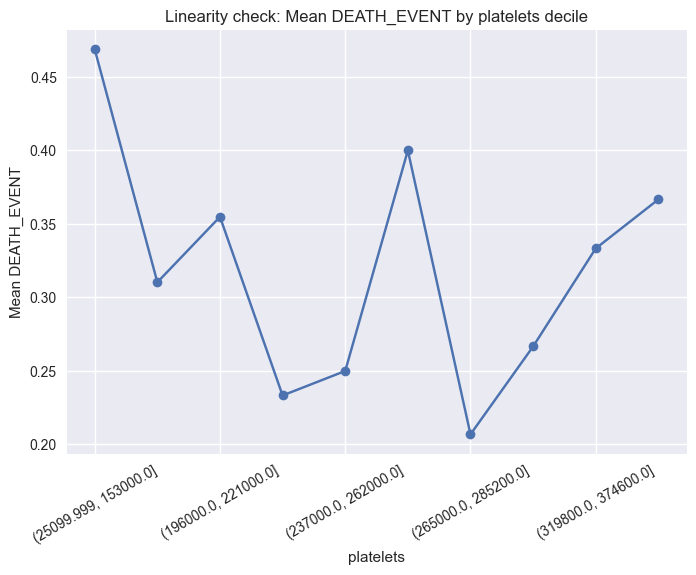

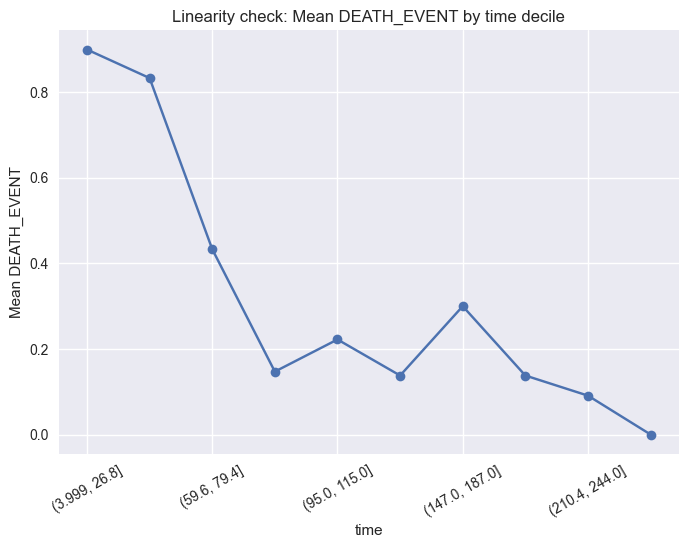

In [21]:
# Linearity of logit (visual check, on original training data)
for col in ['age', 'ejection_fraction', 'serum_creatinine', 'platelets', 'time']:
    df['bin'] = pd.qcut(df[col], 10, duplicates='drop')
    grouped = df.groupby('bin')['DEATH_EVENT'].mean()
    plt.figure()
    grouped.plot(marker='o')
    plt.title(f"Linearity check: Mean DEATH_EVENT by {col} decile")
    plt.ylabel("Mean DEATH_EVENT")
    plt.xlabel(col)
    plt.xticks(rotation=30)
    plt.show()
df.drop('bin', axis=1, inplace=True)


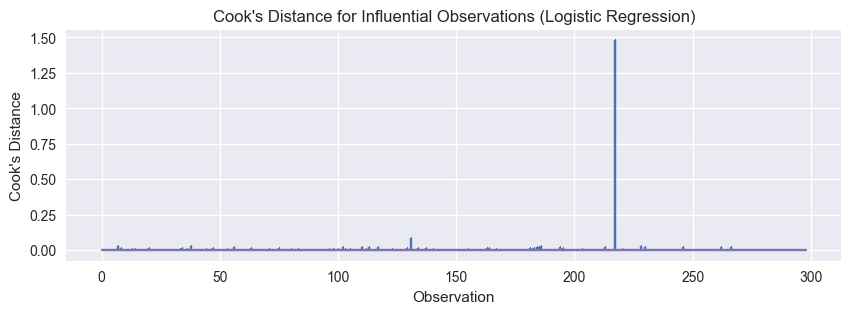

Observations with Cook's Distance > 4/n: 30 (out of 299)


In [22]:
# Cook's distance (on original data, not oversampled)
import statsmodels.api as sm

logit_mod = sm.Logit(y, add_constant(X)).fit(disp=0)
influence = logit_mod.get_influence()
cooks = influence.cooks_distance[0]

plt.figure(figsize=(10,3))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")
plt.title("Cook's Distance for Influential Observations (Logistic Regression)")
plt.xlabel("Observation")
plt.ylabel("Cook's Distance")
plt.show()

print(f"Observations with Cook's Distance > 4/n: {sum(cooks > 4/len(cooks))} (out of {len(cooks)})")


In [23]:
# Perfect separation check
for col in X.columns:
    print(f"{col}:")
    print(df.groupby(col)['DEATH_EVENT'].mean())


age:
age
40.000    0.000000
41.000    0.000000
42.000    0.142857
43.000    0.000000
44.000    0.000000
45.000    0.315789
46.000    0.333333
47.000    0.000000
48.000    1.000000
49.000    0.250000
50.000    0.296296
51.000    0.250000
52.000    0.000000
53.000    0.100000
54.000    0.500000
55.000    0.176471
56.000    0.000000
57.000    0.500000
58.000    0.200000
59.000    0.750000
60.000    0.393939
60.667    0.500000
61.000    0.000000
62.000    0.200000
63.000    0.000000
64.000    0.000000
65.000    0.307692
66.000    0.000000
67.000    0.000000
68.000    0.400000
69.000    0.666667
70.000    0.280000
72.000    0.714286
73.000    0.250000
75.000    0.545455
77.000    0.500000
78.000    0.000000
79.000    0.000000
80.000    0.714286
81.000    0.000000
82.000    1.000000
85.000    0.500000
86.000    1.000000
87.000    1.000000
90.000    0.666667
94.000    1.000000
95.000    1.000000
Name: DEATH_EVENT, dtype: float64
ejection_fraction:
ejection_fraction
14    1.000000
15    1.0000

## 5. Hyperparameter Tuning: Logistic Regression & Random Forest


In [24]:
# Logistic Regression: Tune C (inverse regularization), solver
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced']
}
lr = LogisticRegression(max_iter=1000, random_state=42)
lr_gs = GridSearchCV(lr, lr_params, cv=5, scoring='roc_auc', n_jobs=-1)
lr_gs.fit(X_res, y_res)
print("Best Logistic Regression Params:", lr_gs.best_params_)
print("Best CV ROC AUC: %.3f" % lr_gs.best_score_)


/Users/cholponzhakshylykova/Desktop/SDS/Heart-Attack-Risk/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cholponzhakshylykova/Desktop/SDS/Heart-Attack-Risk/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

Best Logistic Regression Params: {'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
Best CV ROC AUC: 0.921


/Users/cholponzhakshylykova/Desktop/SDS/Heart-Attack-Risk/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cholponzhakshylykova/Desktop/SDS/Heart-Attack-Risk/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

In [25]:
# Random Forest: Tune n_estimators, max_depth, min_samples_split
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}
rf = RandomForestClassifier(random_state=42)
rf_gs = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf_gs.fit(X_res, y_res)
print("Best Random Forest Params:", rf_gs.best_params_)
print("Best CV ROC AUC: %.3f" % rf_gs.best_score_)


Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Best CV ROC AUC: 0.953


## 6. Evaluation: Test Set Results


In [26]:
# Use the best estimators for final prediction/evaluation
best_lr = lr_gs.best_estimator_
best_rf = rf_gs.best_estimator_

probs_lr = best_lr.predict_proba(X_test)[:,1]
preds_lr = best_lr.predict(X_test)
probs_rf = best_rf.predict_proba(X_test)[:,1]
preds_rf = best_rf.predict(X_test)

print("Best Logistic Regression ROC AUC: %.3f" % roc_auc_score(y_test, probs_lr))
print("Best Random Forest ROC AUC: %.3f" % roc_auc_score(y_test, probs_rf))


Best Logistic Regression ROC AUC: 0.873
Best Random Forest ROC AUC: 0.867


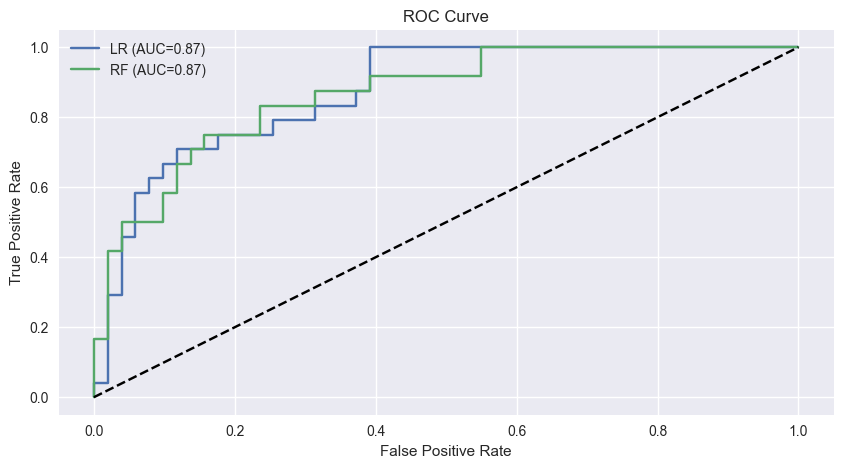

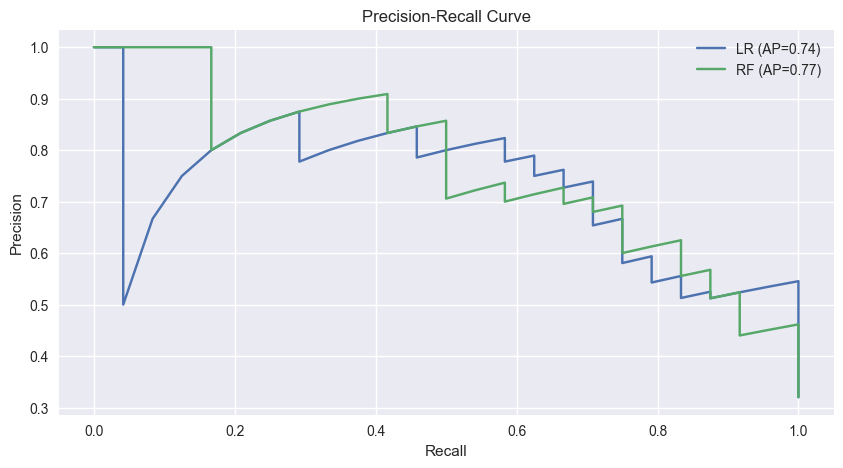

In [27]:
# ROC and Precision-Recall curves
plt.figure(figsize=(10,5))
for name, probs in zip(['LR','RF'], [probs_lr, probs_rf]):
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for name, probs in zip(['LR','RF'], [probs_lr, probs_rf]):
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


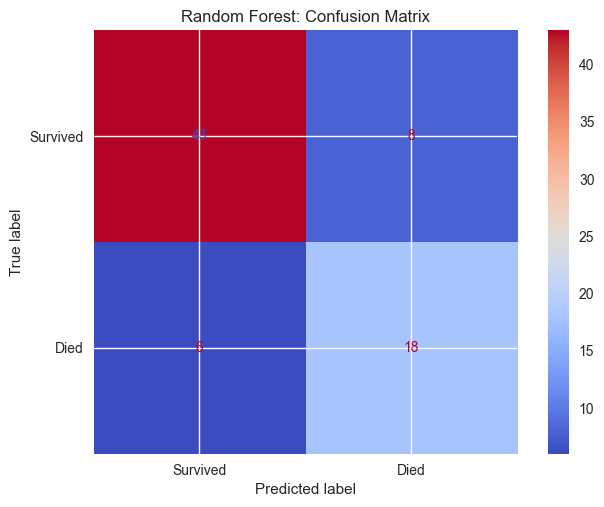

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86        51
           1       0.69      0.75      0.72        24

    accuracy                           0.81        75
   macro avg       0.78      0.80      0.79        75
weighted avg       0.82      0.81      0.82        75



In [28]:
# Confusion matrix and classification report (Random Forest)
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, preds_rf)
ConfusionMatrixDisplay(cm, display_labels=['Survived','Died']).plot(cmap='coolwarm')
plt.title("Random Forest: Confusion Matrix")
plt.show()

print("Random Forest Classification Report:\n", classification_report(y_test, preds_rf))


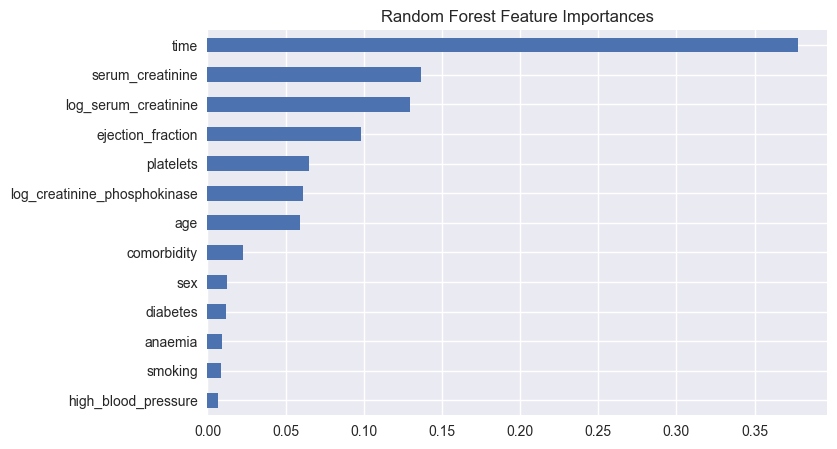

In [29]:
# Random Forest Feature Importance
importances = pd.Series(best_rf.feature_importances_, index=features)
importances.sort_values().plot.barh(figsize=(8,5))
plt.title("Random Forest Feature Importances")
plt.show()


## 7. (Optional) SHAP: Model Explainability


In [30]:
try:
    import shap
    explainer = shap.TreeExplainer(best_rf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values[1], X_test)
except ImportError:
    print("SHAP not installed (pip install shap to enable explainability plots).")


SHAP not installed (pip install shap to enable explainability plots).


## 8. Subgroup Survival Analysis (Kaplan-Meier by sex, diabetes, high BP)


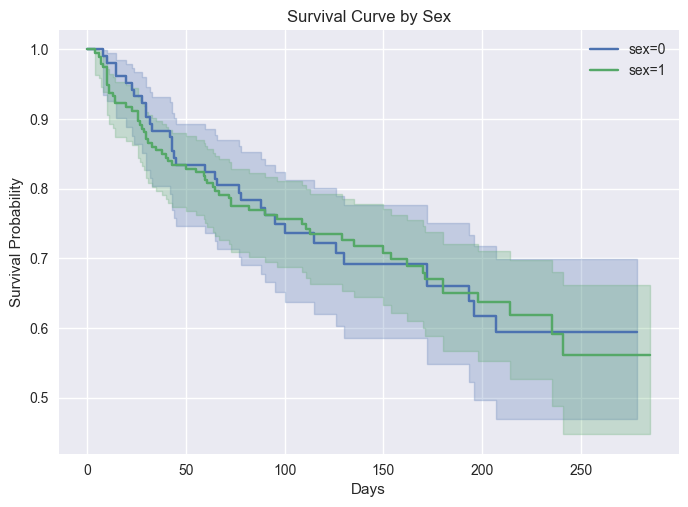

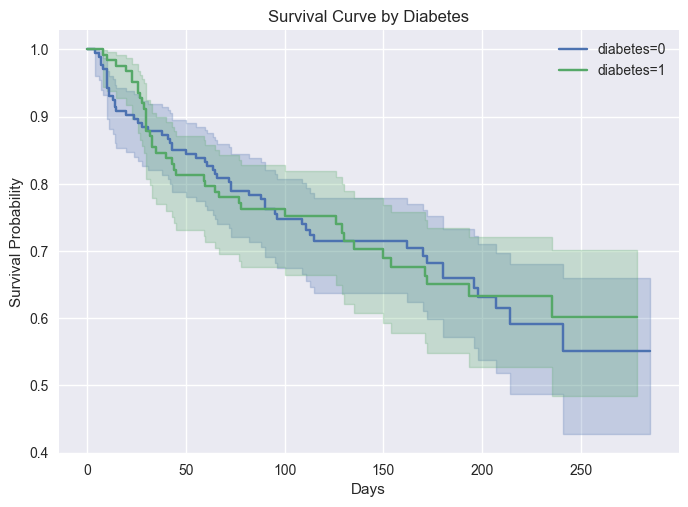

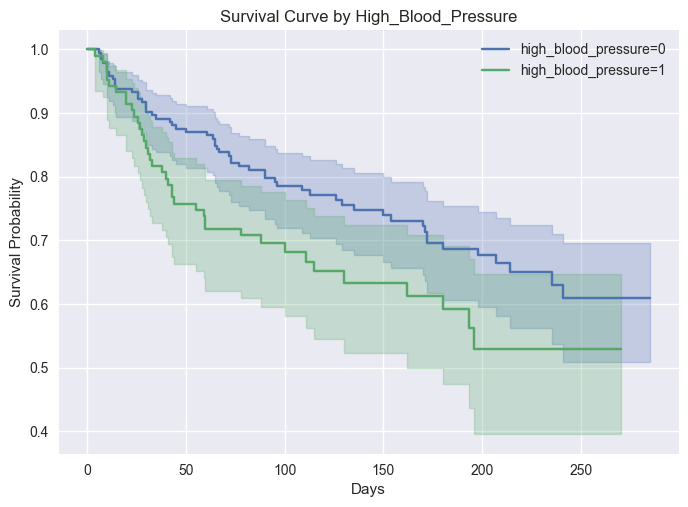

Exception ignored in: <function ResourceTracker.__del__ at 0x106dfdb20>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.4/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.4/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.4/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110b65b20>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.4/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.4/Frameworks/Python.framework/Versi

In [31]:
from lifelines import KaplanMeierFitter

for col in ['sex','diabetes','high_blood_pressure']:
    for val in sorted(df[col].unique()):
        label = f"{col}={val}"
        ix = df[col]==val
        kmf = KaplanMeierFitter()
        kmf.fit(df.loc[ix,'time'], event_observed=df.loc[ix,'DEATH_EVENT'], label=label)
        kmf.plot_survival_function()
    plt.title(f"Survival Curve by {col.title()}")
    plt.xlabel("Days")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.show()


## 9. Clinical Insights & Next Steps

- Imbalance addressed with SMOTE and class weights.
- Hyperparameter tuning improved model ROC AUC.
- Key predictors: age, ejection fraction, serum creatinine, comorbidity.
- High-risk subgroups: age > 70, high serum creatinine, multiple comorbidities.
- Next steps: external validation, deeper explainability, and more advanced models if needed.
